# To test data

In [1]:
def load_data(file_name):
    origin_data = open(file_name, 'rt')
    structure = []
    energy = []
    for line in origin_data:
        if 'adsorption' in line:
            tmp = line.split('\n')[0]
            if 'alloy' in line:
                tmp = tmp.split('./')[1]
                structure.append(tmp)
            else:
                energy.append(tmp)
    return structure, energy

In [2]:
str_O, energy_O = load_data('trainset_O')
str_OH, energy_OH = load_data('trainset_OH')
str_OOH, energy_OOH = load_data('trainset_OOH')
str_full, energy_full = load_data('trainset')
print (len(str_O), len(energy_O), len(str_OH), len(energy_OH), len(str_OOH), len(energy_OOH), len(str_full), len(energy_full))

1520 1520 2657 2657 1140 1140 5319 5317


./adsorption_OH/alloy/Au3Re/hcp/homo  
./adsorption_OH/alloy/Au3Re/top

there is no energy data above two structures

# representational matrix using molml

In [3]:
import re
import numpy as np
from pymatgen import Element

import molml
from molml.crystal import SineMatrix

import matplotlib.pyplot as plt

In [4]:
def get_data(dataset, idx):
    full_data = open(dataset, 'rt').read().split('\n\n\n\n')
    tmp_data = re.sub(' +\n','\n',re.sub('\n +','\n',full_data[idx])).split('\n')
    STRUCTURE = tmp_data[0].split('./')[1]
    ele_set = re.sub('\s+',' ',tmp_data[6]).split(' ')
    numbers = list(map(int, re.sub('\s+',' ',tmp_data[7]).split(' ')))
    ELES = ''
    for i in range(len(ele_set)):
        ELES += ele_set[i]*numbers[i]
    ELES = re.findall('[A-Z][^A-Z]*', ELES)
    COORDS = tmp_data[10:10+len(ELES)]
    for i in range(len(ELES)):
        COORDS[i] = list(map(float,re.sub('\s+',' ',COORDS[i]).split(' ')[0:3]))
    UNIT = tmp_data[3:6]
    for i in range(3):
        UNIT[i] = list(map(float, re.sub('\s+',' ',UNIT[i]).split(' ')))
    ENERGY = float(tmp_data[-1].split('= ')[1].split(' eV')[0])
    return STRUCTURE, ELES, np.array(COORDS), np.array(UNIT), ENERGY

In [5]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-')
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

---

In [6]:
STRUCTURE, ELES, COORDS, UNIT, ENERGY = get_data('trainset_O', 1003)
input_type = ("elements", "coords", "unit_cell")
X = (ELES, COORDS, UNIT)
trans = SineMatrix(input_type=input_type)
res = trans.fit_transform([X])
# print (res.reshape(441))

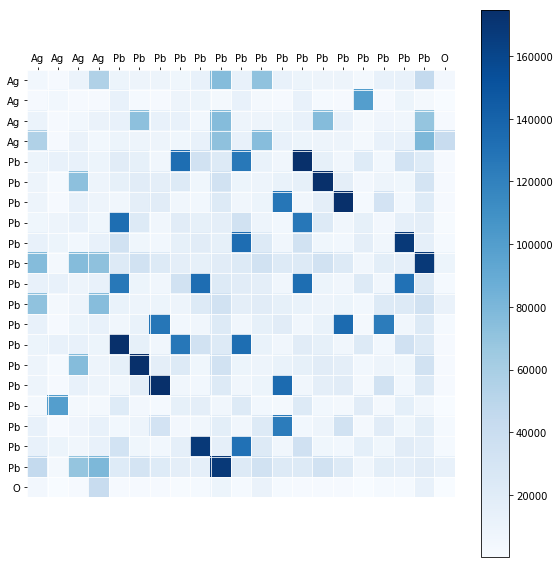

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
im, cbar = heatmap(res.reshape(len(ELES),len(ELES)), ELES, ELES, ax=ax, cmap="Blues")
# we can give a limitation through vmin and vmax
fig.tight_layout()
file_name = STRUCTURE.replace('/',' ') + ' SineMatrix.png'
plt.savefig(file_name, dpi=70)

---

In [8]:
tmp = []
for i in range(1520):
    STRUCTURE, ELES, COORDS, UNIT, ENERGY = get_data('trainset_O', i)
    input_type = ("elements", "coords", "unit_cell")
    X = (ELES, COORDS, UNIT)
    trans = SineMatrix(input_type=input_type)
    res = trans.fit_transform([X])
    in_out_vec = [STRUCTURE] + list(res.reshape(441)) + [ENERGY]
    tmp.append(in_out_vec)

In [9]:
import pandas as pd
import numpy as np

In [10]:
tmp = pd.DataFrame(tmp)
tmp.to_csv('molml_data.csv')